# Second fit

We wish to use a fit to contrain our uncertainties.
We can construct our chi squared as the sum of two functions; we construct a yield chi squared and a chi squared to constrain the scale factors.

We can write the chisquared as:

$$\mathrm{y}_{\chi} = \big(N_{\mathrm{obs_{sig}}} - \sum_{i}^{process} \mathrm{SF}_{i} N_{i} \big)^2
                      + \big(N_{\mathrm{obs_{control}}} - \sum_{i}^{process} \mathrm{SF}_{i} N_{i} \big)^2$$

$$\mathrm{c}_{\chi} = \bigg(\frac{\mathrm{aTT} - \mathrm{eTT}} {sig_{att}} \bigg)^2 + \bigg(\frac{\mathrm{aDY} - \mathrm{eDY}} {sig_{ady}} \bigg)^2$$

$$\chi^2 = \mathrm{y}_{\chi} + \mathrm{c}_{\chi}$$

## Clean Up
- <s>reformat chi-squares so that we can easily include higher order terms.</s>
- <s>New plotting function </s>
- make sure that the yields are calculated correctly.


In [1]:
#Set up
import os, sys
sys.path.append(os.getcwd() + "/../")
from prep_ana_II import *
sys.path.append(os.getcwd() + "/../tools/")
sys.path.append(os.getcwd() + "/../tools/bjetsys/")
from lepton_eff import muonEff, electronEff
from pile_up import pileUpFunction, Min_Bias
from cross_section_calc import calc_cross_stuff, cross_calc, stat_unc_calc, normalization_unc_calc
import pile_up
import BTagCalibrationStandalone as BT


import matplotlib
import warnings


Welcome to JupyROOT 6.10/00
home /home/gunter/WW_analysis/production/Analysis_13TeV
Loading binning options...
Loading plotting options
unc_mc_process and scales are parameter dictionaries


In [2]:
%matplotlib inline

In [3]:
scales, df    = load_testset()
#df = load_presel_w_fDY_fTT_MC(unc="jet")
df = pre_cuts(df[(df.lep2_pt > 25) & (df.mll > 30)], diff_charge=False)
df_da = pre_cuts(load_presel_w_fDY_fTT_DATA(), diff_charge=False)
df_da = df_da[(df_da.lep2_pt > 25) & (df_da.mll > 30)]

df = df[df.metFilter_flag == 0]
df_da = df_da[df_da.metFilter_flag == 0]

df_da["weight"] = np.array([1.0] * df_da.shape[0]) 
warnings.filterwarnings('ignore')

In [4]:
from scipy.optimize import curve_fit, minimize

def c_dy(df, charge_state=""):
    dy_cuts = (df.pred_fDY_WW < .6) & (df.pred_fTT_WW > .6)
    if charge_state == "diff":
        dy_cuts = dy_cuts & (df.lep1_Charge != df.lep2_Charge)
    if charge_state == "same":
        dy_cuts = dy_cuts & (df.lep1_Charge == df.lep2_Charge)
    
    return df[dy_cuts]

def c_tt(df, charge_state=""):
    tt_cuts = (df.pred_fDY_WW > .6) & (df.pred_fTT_WW < .6)
    if charge_state == "diff":
        tt_cuts = tt_cuts & (df.lep1_Charge != df.lep2_Charge)
    if charge_state == "same":
        tt_cuts = tt_cuts & (df.lep1_Charge == df.lep2_Charge)
    
    return df[tt_cuts]

def c_ww(df, charge_state=""):
    ww_cuts = (df.pred_fDY_WW > .9) & (df.pred_fTT_WW > .6)
    if charge_state == "diff":
        ww_cuts = ww_cuts & (df.lep1_Charge != df.lep2_Charge)
    if charge_state == "same":
        ww_cuts = ww_cuts & (df.lep1_Charge == df.lep2_Charge)
    
    return df[ww_cuts]
    

In [5]:
data_control_dic = {}
mc_control_dic   = {}

def pack_data_dic(data_dic, df_da):
    charge = "diff"
    data_dic["dy"] = float(c_dy(df_da, charge).shape[0])
    data_dic["tt"] = float(c_tt(df_da, charge).shape[0])
    data_dic["sig"]= float(c_ww(df_da, charge).shape[0])
    
def pack_mc_dic(mc_dic, df, df_da):
    mc_c_dy = {'W1JetsToLNu':0}
    mc_c_tt = {'W1JetsToLNu':0}
    mc_s    = {'W1JetsToLNu':0}
    
    for p in df.process_decay.unique():
        h = 1
        if 'DYJetsToLL_M-50' in p:
            h *= 1
        if 'ttbar_leptonic' in p:
            h *= 1
        if p in df[df.process == "WJ"].process_decay.unique(): continue
        mc_c_dy[p] = c_dy(df[(df.process_decay == p)], "diff").weight.sum() * h * scales[p]
        mc_c_tt[p] = c_tt(df[(df.process_decay == p)], "diff").weight.sum() * h * scales[p] 
        mc_s[p]    = c_ww(df[(df.process_decay == p)], "diff").weight.sum() * h * scales[p]


        mc_c_dy['W1JetsToLNu'] += c_dy(df[(df.process_decay == p)], "same").weight.sum() * h * scales[p]
        mc_c_tt['W1JetsToLNu'] += c_tt(df[(df.process_decay == p)], "same").weight.sum() * h * scales[p] 
        mc_s['W1JetsToLNu']    += c_ww(df[(df.process_decay == p)], "same").weight.sum() * h * scales[p]


    mc_c_dy['W1JetsToLNu'] -= c_dy(df_da, "same").shape[0]
    mc_c_tt['W1JetsToLNu'] -= c_tt(df_da, "same").shape[0] 
    mc_s['W1JetsToLNu']    -= c_ww(df_da, "same").shape[0]

    mc_dic["dy"] = mc_c_dy
    mc_dic["tt"] = mc_c_tt
    mc_dic["sig"]= mc_s 
    

In [6]:
pack_data_dic(data_control_dic, df_da)
pack_mc_dic(mc_control_dic, df, df_da)

In [7]:
#data_control_dic 
#mc_control_dic
def func_c_dy(mc_dic, aWW, aTT, aDY):
    every_thing_else = 0
    mc_c_dy = mc_dic["dy"]
    
    for i in mc_c_dy:
        if i == "WW" or i == 'ttbar_leptonic' or i == 'DYJetsToLL_M-50':
            continue
        every_thing_else += mc_c_dy[i]
    return aWW * mc_c_dy["WW"] + aTT * mc_c_dy['ttbar_leptonic'] +  aDY * mc_c_dy['DYJetsToLL_M-50'] + every_thing_else 
###########
def func_c_tt(mc_dic, aWW, aTT, aDY):
    every_thing_else = 0
    mc_c_tt = mc_dic["tt"]
    
    for i in mc_c_tt:
        if i == "WW" or i == 'ttbar_leptonic' or i == 'DYJetsToLL_M-50':
            continue
        every_thing_else += mc_c_tt[i]
    return aWW * mc_c_tt["WW"] + aTT * mc_c_tt['ttbar_leptonic'] +  aDY * mc_c_tt['DYJetsToLL_M-50'] + every_thing_else 
##########
def func_s(mc_dic, aWW, aTT, aDY):
    every_thing_else = 0
    mc_s = mc_dic["sig"]
    
    for i in mc_s:
        if i == "WW" or i == 'ttbar_leptonic' or i == 'DYJetsToLL_M-50':
            continue
        every_thing_else += mc_s[i]
    return aWW * mc_s["WW"] + aTT * mc_s['ttbar_leptonic'] +  aDY * mc_s['DYJetsToLL_M-50'] + every_thing_else



In [8]:
def min_func(x):
    data_c_dy = data_control_dic["dy"]
    data_c_tt = data_control_dic["tt"]
    data_s    = data_control_dic["sig"]
    
    fit_c_dy = (func_c_dy(mc_control_dic, x[0], x[1], x[2]) - data_c_dy) / data_c_dy**0.5
    fit_c_tt = (func_c_tt(mc_control_dic, x[0], x[1], x[2]) - data_c_tt) / data_c_tt**0.5
    fit_s =    (func_s(mc_control_dic, x[0], x[1], x[2]) - data_s)    / data_s**0.5
    
    constraint_fit = (x[1] - 1)**2/0.05**2 + (x[2] - 1)**2/0.03**2

    print x, fit_c_dy**2 , fit_c_tt**2 , fit_s**2, constraint_fit
    return fit_c_dy**2 + fit_c_tt**2 + fit_s**2 + constraint_fit
    
temp1 = minimize(min_func, [1.,1., 1.], method='SLSQP')

[ 1.  1.  1.] 3.24840233619 53.6891407828 1280.2062896 0.0
[ 1.  1.  1.] 3.24840233619 53.6891407828 1280.2062896 0.0
[ 1.00000001  1.          1.        ] 3.24840260753 53.6891349317 1280.20620958 0.0
[ 1.          1.00000001  1.        ] 3.24840240098 53.689095801 1280.20626731 8.881784197e-14
[ 1.          1.          1.00000001] 3.2484582869 53.6891335016 1280.20627721 2.46716227694e-13
[ 5745.53549194  4510.89595032 -2433.74711609] 6.25837787999e+12 1.00344129633e+12 247028071541.0 14722324059.0
[ 575.45354919  451.98959503 -242.47471161] 62582967209.5 10033091827.6 2467080752.65 147223240.59
[ 58.44535492  46.0989595  -23.34747116] 625748515.95 100198852.545 24351951.9141 1472232.4059
[ 6.74453549  5.50989595 -1.43474712] 6249372.43937 988829.789383 212774.621707 14722.324059
[ 1.57445355  1.4509896   0.75652529] 61685.3467073 8620.26131143 193.920277649 147.22324059
[ 1.05744535  1.04509896  0.97565253] 538.910024911 7.23597931198 949.220412867 1.4722324059
[ 1.02262607  1.01776

In [9]:
print temp1
print func_s(mc_control_dic,   temp1.x[0], temp1.x[1], temp1.x[2])
print func_c_dy(mc_control_dic,temp1.x[0], temp1.x[1], temp1.x[2])
print func_c_tt(mc_control_dic,temp1.x[0], temp1.x[1], temp1.x[2])

     fun: 0.30326356689885586
     jac: array([ -5.59128821e-05,   8.94069672e-07,  -3.25217843e-06])
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([ 1.484554  ,  0.9734563 ,  0.99595322])
24263.9955557
1113795.96768
104588.294974


# Make plots

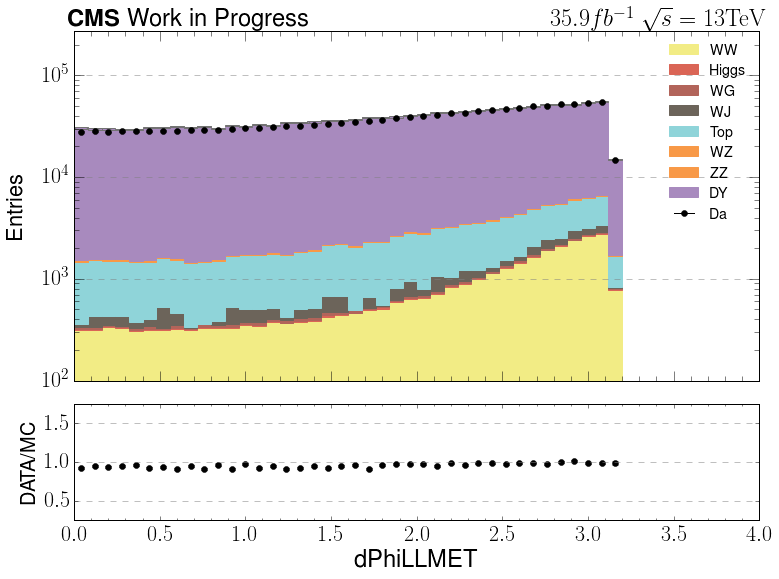

In [5]:
a = full_bin_plot(df, df_da, "dPhiLLMET",scales=scales, x_range=None, y_range=None)

In [11]:
df_bin

{'DYJetsToLL_M-10to50': [array([-0.70903265,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  array([ 499.74850464,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ], dtype=float32)],
 'DYJetsToLL_M-50': [array([ 879.88818359,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ], dtype=float32),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  array([ 4108.87597656,     0.        ,     0.        ,     0.        ,
             0.        ,     0.        ,     0.        

In [12]:
df_da_bin

{'Da': [array([ 11005.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.]),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
  array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
  array([ 11005.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.])],
 'plotting': {'title': 'numb BJet', 'y_label': 'Entries'}}

In [13]:
df_da.query("lep1_Charge == lep2_Charge & pred_fDY_WW > .9 & pred_fTT_WW > .9").shape[0]

1258

In [14]:
tot = 0
for process in df.process_decay.unique():
    tot += df[df.process_decay == process].query("lep1_Charge == lep2_Charge & pred_fDY_WW > .9 & pred_fTT_WW > .9 & process != 'WJ'").weight.sum() *\
    scales[process]
    
print tot    

752.921368018


In [15]:
1258 - 752

506

(<matplotlib.figure.Figure at 0x7f5f4ebfad90>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f412e3790>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5f412147d0>], dtype=object))

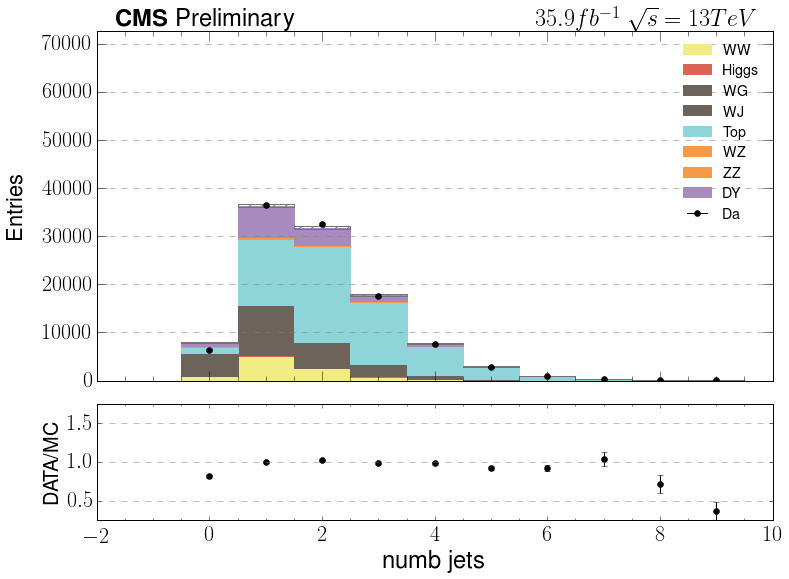

In [16]:
df_bin = bin_df(df[(df.pred_fDY_WW > .6) & (df.pred_fTT_WW < .6) & (df.lep1_Charge != df.lep2_Charge)], scales=scales,\
                binned_feature='numb_jets',)
df_da_bin = bin_df(df_da[(df_da.pred_fDY_WW > .6) & (df_da.pred_fTT_WW < .6) & (df_da.lep1_Charge != df_da.lep2_Charge)],\
                   binned_feature='numb_jets')
df_bin['ttbar_leptonic'][0] *= .65
for i in df_bin:
    if i in ['W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu', 'W4JetsToLNu']:
        df_bin[i][0] *= 2.5
full_plot(df_bin, df_da_bin, color="color_1",  logy=False,)# y_range=(0, 24000))

(<matplotlib.figure.Figure at 0x7f5f41764710>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f411e5410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5f41465bd0>], dtype=object))

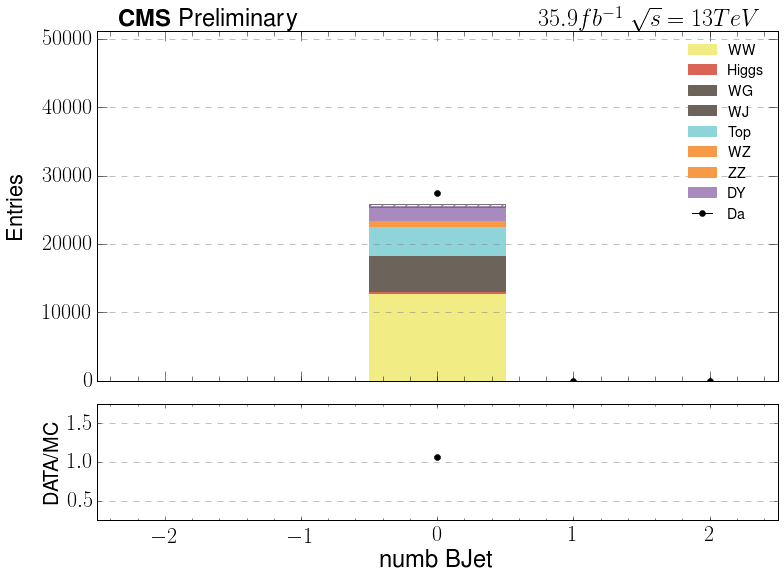

In [17]:
df_bin = bin_df(df[(df.pred_fDY_WW > .9) & (df.pred_fTT_WW > .6)], scales=scales, binned_feature='numb_BJet',)
df_da_bin = bin_df(df_da[(df_da.pred_fDY_WW > .9) & (df_da.pred_fTT_WW > .6)], binned_feature='numb_BJet')

full_plot(df_bin, df_da_bin, color="color_1", logy=False, x_range=(-2.5, 2.5))

In [18]:
process_yields(df[(df.pred_fDY_WW > .6) & (df.pred_fTT_WW < .6) & (df.numb_jets >= 2)], df_da[(df_da.pred_fDY_WW > .6) & (df_da.pred_fTT_WW < .6) &\
                                                                       (df_da.numb_jets >= 2)], scales=scales)

WW 32.9185641409
GluGluWWTo2L2Nu 2.09576367473
DYJetsToLL_M-50 1051.65633084
DYJetsToLL_M-10to50 109.386615129
ttbar_leptonic 3074.62174347
ttbar_semileptonic 9733.96581719
Tbar_tW-channel 143.10931471
Tbar_t-channel 73.5760132405
T_tW-channel 173.49183
T_s-channel 26.2445740847
T_t-channel 156.351107502
WZJetsTo2L2Q 6.08773026875
WZJetsTo3LNu 416.701405057
ZZJetsTo2L2Q 3.98921150525
ZZJetsTo2L2Nu 0.311890276447
WGToLNuG 472.570298591
GluGluHToWWTo2L2Nu 0.0
15958 15477.0788535


,Diff Flavor,Process,Same Flavor
0,2362,WW,988
1,281,GluGluWWTo2L2Nu,87
2,2643,WW,1075
3,2038,DY,3475
4,44825,Top,14525
5,352,WZ,138
6,9,ZZ,23
7,297,WG(*),68
8,65,Higgs,16
9,241,WJ,240


In [19]:
process_yields(df[(df.pred_fDY_WW < .6) & (df.pred_fTT_WW > .6)], df_da[(df_da.pred_fDY_WW < .6) & (df_da.pred_fTT_WW > .6)], scales=scales)

WW 28.4060755024
GluGluWWTo2L2Nu 0.0
DYJetsToLL_M-50 3929.76729973
DYJetsToLL_M-10to50 27.0591462824
ttbar_leptonic 37.0568687665
ttbar_semileptonic 32.1784299579
Tbar_tW-channel 4.6329565206
Tbar_t-channel 3.57614995782
T_tW-channel 2.96633230809
T_s-channel 2.12281847472
T_t-channel 6.89035199281
WZJetsTo2L2Q 0.754280496243
WZJetsTo3LNu 179.720962977
ZZJetsTo2L2Q 0.468031561546
ZZJetsTo2L2Nu 0.330461572858
WGToLNuG 66.1507907399
GluGluHToWWTo2L2Nu 0.0
6443 4322.08141421


,Diff Flavor,Process,Same Flavor
0,329,WW,5002
1,19,GluGluWWTo2L2Nu,220
2,348,WW,5222
3,14281,DY,1095812
4,87,Top,1433
5,13,WZ,341
6,2,ZZ,125
7,16,WG(*),47
8,19,Higgs,70
9,420,WJ,1701


In [20]:
process_yields(df[(df.pred_fDY_WW > .9) & (df.pred_fTT_WW > .9)], df_da[(df_da.pred_fDY_WW > .9) & (df_da.pred_fTT_WW > .9)], scales=scales)

WW 46.8187249758
GluGluWWTo2L2Nu 1.3012418968
DYJetsToLL_M-50 71.7190053428
DYJetsToLL_M-10to50 -0.0427601769169
ttbar_leptonic 22.7429752609
ttbar_semileptonic 7.96501083821
Tbar_tW-channel 3.38655756579
Tbar_t-channel 2.88699653559
T_tW-channel 3.31278316234
T_s-channel 0.883142622851
T_t-channel 4.2648513023
WZJetsTo2L2Q 0.0309894165637
WZJetsTo3LNu 133.645493105
ZZJetsTo2L2Q 0.116575221372
ZZJetsTo2L2Nu 0.0723839191209
WGToLNuG 453.817397029
GluGluHToWWTo2L2Nu 0.0
1258 752.92138909


,Diff Flavor,Process,Same Flavor
0,5552,WW,693
1,390,GluGluWWTo2L2Nu,63
2,5942,WW,756
3,821,DY,59
4,570,Top,78
5,113,WZ,21
6,1,ZZ,8
7,374,WG(*),0
8,67,Higgs,12
9,479,WJ,26


# End

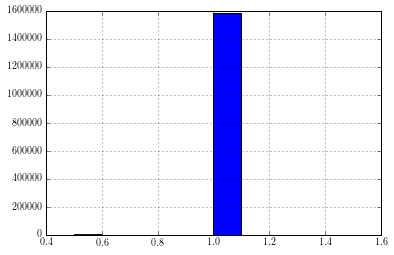

In [21]:
df_da.weight.hist()

In [22]:
df_da["weight"] = np.array([1.0] * df_da.shape[0]) 

In [23]:
process_yields(df.query("pred_fDY_WW > .9 & pred_fTT_WW > .9"),\
               df_da.query("pred_fDY_WW > .9 & pred_fTT_WW > .9"),\
               scales=scales)

WW 46.8187249758
GluGluWWTo2L2Nu 1.3012418968
DYJetsToLL_M-50 71.7190053428
DYJetsToLL_M-10to50 -0.0427601769169
ttbar_leptonic 22.7429752609
ttbar_semileptonic 7.96501083821
Tbar_tW-channel 3.38655756579
Tbar_t-channel 2.88699653559
T_tW-channel 3.31278316234
T_s-channel 0.883142622851
T_t-channel 4.2648513023
WZJetsTo2L2Q 0.0309894165637
WZJetsTo3LNu 133.645493105
ZZJetsTo2L2Q 0.116575221372
ZZJetsTo2L2Nu 0.0723839191209
WGToLNuG 453.817397029
GluGluHToWWTo2L2Nu 0.0
1258 752.92138909


,Diff Flavor,Process,Same Flavor
0,5552,WW,693
1,390,GluGluWWTo2L2Nu,63
2,5942,WW,756
3,821,DY,59
4,570,Top,78
5,113,WZ,21
6,1,ZZ,8
7,374,WG(*),0
8,67,Higgs,12
9,479,WJ,26
